## 1. Import data

In [1]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()    


In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

titanic_train = load_titanic_data("train.csv")
titanic_test = load_titanic_data("test.csv")

titanic_train_labels = titanic_train["Survived"].values
del titanic_train["Survived"]
titanic_train_labels.mean()

0.3838383838383838

Approximately 38% of the passengers in the training set survived

## 2. Exploration of training data

In [3]:
titanic_train.shape

(891, 11)

In [4]:
titanic_train.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
titanic_train.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

"Age", "Cabin" and "Embarked" variable contain null values

In [6]:
len(titanic_train[titanic_train["Embarked"].isna() == True])

2

In [7]:
len(titanic_train[titanic_train["Cabin"].isna() == True])

687

In [8]:
len(titanic_train[titanic_train["Age"].isna() == True])

177

"Cabin" has 687 null values, while "Age" and "Embarked" have 177 and 2 null values respectively <br>
"Age" is a numerical variable and the null values will have to be imputed via some strategy <br>
"Embarked" and "Cabin" are categorical variables, however, "Embarked" will likely be imputed via some strategy due to it only having 2 null values

In [9]:
titanic_train["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [10]:
titanic_train["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
titanic_train["Age"].describe()

count    714.000000
mean      29.699113
std       14.526507
min        0.416700
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [12]:
titanic_train["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [13]:
titanic_train["SibSp"].describe()

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64

In [14]:
titanic_train["Parch"].describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64

The relevant variables that will be used to train the model are split into numerical variables and categorical variables <br>
Each set of variables will go through a separate data pre-processing pipeline, and then unioned together to consolidate the prepared training data

In [15]:
num_variables = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
cat_variables = ["Sex", "Embarked"]

## 3. Data pre-processing

A few helper classes are created to form the pipeline for each set of variables: <br> <br>
    1. VariableSelector: Selects a variables from the training data to pre-process, or create new variables for feature engineering <br> <br>
    2. NumericalValueImputer: Uses a strategy (mean or median) and a list of variable(s) to aggregate, to impute null values in numerical variables (eg Impute median age for each gender for null age values) <br> <br>
    3. CategoricalValueImputer: Uses a mode strategy to impute null values in categorical variables

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin 

class VariableSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_keep, age_buckets = False, comb_sibsp_parch = False):
        self.columns_to_keep = columns_to_keep
        self.age_buckets = age_buckets
        self.comb_sibsp_parch = comb_sibsp_parch
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        new_columns = self.columns_to_keep.copy()
        if self.age_buckets:
            bucket_size = 15
            X["Age_bucket"] = (X["Age"]//bucket_size) * bucket_size
            new_columns.remove("Age")
            new_columns.append("Age_bucket")
             
        if self.comb_sibsp_parch:
            X["SibSp_Parch"] = X["SibSp"] + X["Parch"]
            new_columns.remove("SibSp")
            new_columns.remove("Parch")
            new_columns.append("SibSp_Parch")
             
        X =  X[new_columns]
        
        return X

In [17]:
class NumericalValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, impute_column, agg_columns, strategy):
        self.impute_column = impute_column
        self.agg_columns = agg_columns
        self.strategy = strategy
        
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        if self.strategy == "median":
            groupby_df = pd.DataFrame(X.groupby(self.agg_columns).median()[self.impute_column])
        elif self.strategy == "mean":
            groupby_df = pd.DataFrame(X.groupby(self.agg_columns).mean()[self.impute_column])
                
        X[self.impute_column] =  X[self.impute_column].fillna(X[self.agg_columns].apply(lambda x: groupby_df.loc[tuple(x[col] for col in self.agg_columns)].values[0], axis = 1))
        
        return X

In [18]:
class CategoricalValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, impute_column):
        self.impute_column = impute_column
    
    def fit(self, X, y = None):
        return self
        
    def transform(self, X):
        X[self.impute_column] = X[self.impute_column].fillna(X[self.impute_column].mode()[0])
        
        return X

<b>Pipeline for numerical variables:<b><br>
1. Impute null values in "Age" using the median value of each "Pclass" <br> <br>
2. Impute null values in "Fare" using the median value of each "Pclass" <br> <br>
3. Select the relevant numerical variables <br> <br>
4. Scale numerical variables using sklearn StandardScaler

In [19]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_pipeline = Pipeline([("median_age_by_pclass_imputer", NumericalValueImputer("Age", ["Pclass"], "median")),
                         ("median_fare_by_pclass_imputer", NumericalValueImputer("Fare", ["Pclass"], "median")),
                         ("attr_selector", VariableSelector(num_variables, age_buckets = False, comb_sibsp_parch = False)),
                         ("standard_scaler", StandardScaler())])

<b>Pipeline for categorical variables:<b><br>
1. Impute null values in "Embarked" using the mode value <br> <br>
3. Select the relevant categorical variables <br> <br>
4. One-hot encode catgorical variables using sklearn OneHotEncoder

In [20]:
cat_pipeline = Pipeline([("embarked_mode_value_imputer", CategoricalValueImputer("Embarked")),
                         ("attr_selector", VariableSelector(cat_variables)),
                         ("one_hot_encoder", OneHotEncoder(sparse=False))])

Full pipeline unions numerical variables and categorical variables after passing through their respective pipelines

In [21]:
full_pipeline = FeatureUnion([("num_pipeline", num_pipeline),
                              ("cat_pipeline", cat_pipeline)])

titanic_train_final = full_pipeline.fit_transform(titanic_train)

## 4. Model training

### 4a) Stochastic Gradient Descent Classifier

In [22]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(titanic_train_final, titanic_train_labels)

SGDClassifier(random_state=42)

In [23]:
from sklearn.model_selection import cross_val_score, cross_val_predict
print("Mean accuracy = {}".format(cross_val_score(sgd_clf, titanic_train_final, titanic_train_labels, cv = 8, scoring = "accuracy").mean()))

Mean accuracy = 0.7845177767052767


Training a stochastic gradient descent classifier, with 8-fold cross validation, the average accuracy is about 78%. The model was able to correctly predict is a passenger survived or not for about 78% of the training data

In [24]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve, accuracy_score
y_pred = cross_val_predict(sgd_clf, titanic_train_final, titanic_train_labels, cv = 8)
y_pred_scores = cross_val_predict(sgd_clf, titanic_train_final, titanic_train_labels, cv = 8, method = "decision_function")

print("SGD Classifier, 8 folds")
print("Precision = {}".format(precision_score(titanic_train_labels, y_pred)))
print("Recall = {}".format(recall_score(titanic_train_labels, y_pred)))
print("Accuracy = {}".format(accuracy_score(titanic_train_labels, y_pred)))

SGD Classifier, 8 folds
Precision = 0.7777777777777778
Recall = 0.6140350877192983
Accuracy = 0.7845117845117845


True Positive (TP) - Actual: Survived, Predicted: Survived <br>
True Negative (TN) - Actual: Does not survive, Predicted: Does not survive <br>
False Positive (FP) - Actual: Does not survive, Predicted: Survived <br>
False Negative (FN) - Actual: Survived, Predicted: Does not survive <br> <br>

Precision = TP/(TP+FP) <br>
The precision score measures the ratio of correctly predicted positives to all predicted positives <br> <br>

Recall = TP/(TP+FN) <br>
The precision score measures the ratio of correctly predicted positives to all actual positives <br> <br>

Accuracy = (TP+TN)/(TP+TN+FP+FN) <br> 
The accuracy score measures the ratio of correctly predicted outcomes to the whole dataset <br> <br>

The SGD classifer has a precision score of 0.78, indicating that it correctly predicts surviving passengers 78% of the time <br>
The SGD classifier has a recall score of 0.61, indicating that it correctly predicts about 61% of the training data surviving passengers <br>

Intrestingly to note, in this context of training a classifer to predict surviving passengers, a higher precision score/lower recall score is preferred. This would mean preferring a classifier that places more emphasis on reducing false positives and correctly predicting surviving passengers

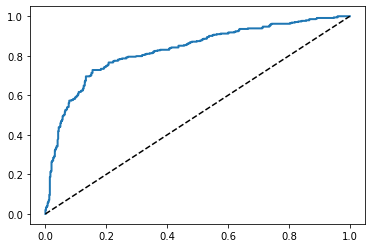

SGD Classifier, 8 folds
AUC = 0.8288488373331628


In [25]:
import matplotlib.pyplot as plt
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], "k--")

from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds  = roc_curve(titanic_train_labels, y_pred_scores)
plot_roc_curve(fpr, tpr)
plt.show()
print("SGD Classifier, 8 folds")
print("AUC = {}".format(roc_auc_score(titanic_train_labels, y_pred_scores)))

Training a stochastic gradient descent classifier, with 8-fold cross validation, the area under the recieved operating curve is 0.83, which is quite decent as it is quite far away from the diagonal dotted line which represents a purely random classifier

### 4b) Random Forest Classifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(titanic_train_final, titanic_train_labels)


RandomForestClassifier(random_state=42)

In [27]:
forest_clf_probs = cross_val_predict(forest_clf, titanic_train_final, titanic_train_labels, cv = 8, method = "predict_proba")
y_pred_scores_forest = forest_clf_probs[:,1]
y_pred_forest = (y_pred_scores_forest >= 0.5)

print("Random Forest Classifier, 8 folds")
print("Precision = {}".format(precision_score(titanic_train_labels, y_pred_forest)))
print("Recall = {}".format(recall_score(titanic_train_labels, y_pred_forest)))
print("Accuracy = {}".format(accuracy_score(titanic_train_labels, y_pred_forest)))

Random Forest Classifier, 8 folds
Precision = 0.7634730538922155
Recall = 0.7456140350877193
Accuracy = 0.813692480359147


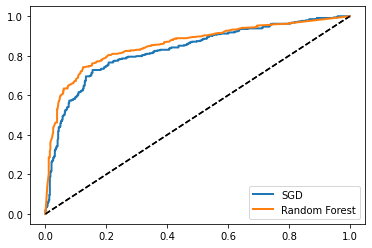

Random Forest Classifier, 8 folds
AUC = 0.8585040317855963


In [28]:
fpr_forest, tpr_forest, thresholds_forest  = roc_curve(titanic_train_labels, y_pred_scores_forest)
plot_roc_curve(fpr, tpr, label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")
plt.legend(loc = "lower right")
plt.show()
print("Random Forest Classifier, 8 folds")
print("AUC = {}".format(roc_auc_score(titanic_train_labels, y_pred_scores_forest)))

### 4c) Support Vector Machine Classifier

In [29]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(titanic_train_final, titanic_train_labels)

SVC(gamma='auto')

In [30]:
svm_clf_pred = cross_val_predict(svm_clf, titanic_train_final, titanic_train_labels, cv = 8)
svm_clf_scores = cross_val_predict(svm_clf, titanic_train_final, titanic_train_labels, cv = 8, method = "decision_function")

print("Support Vector Classifier, 8 folds")
print("Precision = {}".format(precision_score(titanic_train_labels, svm_clf_pred)))
print("Recall = {}".format(recall_score(titanic_train_labels, svm_clf_pred)))
print("Accuracy = {}".format(accuracy_score(titanic_train_labels, svm_clf_pred)))

Support Vector Classifier, 8 folds
Precision = 0.813953488372093
Recall = 0.716374269005848
Accuracy = 0.8282828282828283


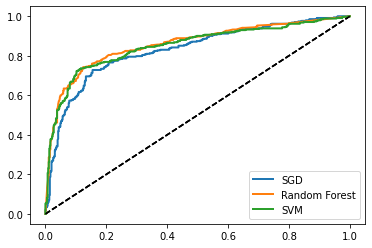

Support Vector Classifier, 8 folds
AUC = 0.8503339404978749


In [31]:
fpr_svm, tpr_svm, thresholds_svm  = roc_curve(titanic_train_labels, svm_clf_scores)
plot_roc_curve(fpr, tpr, label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, label = "Random Forest")
plot_roc_curve(fpr_svm, tpr_svm, label = "SVM")
plt.legend(loc = "lower right")
plt.show()
print("Support Vector Classifier, 8 folds")
print("AUC = {}".format(roc_auc_score(titanic_train_labels, svm_clf_scores)))

## 5) Model evaluation and comparison

In [32]:
sgd_clf_precision = precision_score(titanic_train_labels, y_pred)
sgd_clf_recall = recall_score(titanic_train_labels, y_pred)
sgd_clf_accuracy = accuracy_score(titanic_train_labels, y_pred)
sgd_clf_AUC = roc_auc_score(titanic_train_labels, y_pred_scores)

forest_clf_precision = precision_score(titanic_train_labels, y_pred_forest)
forest_clf_recall = recall_score(titanic_train_labels, y_pred_forest)
forest_clf_accuracy = accuracy_score(titanic_train_labels, y_pred_forest)
forest_clf_AUC = roc_auc_score(titanic_train_labels, y_pred_scores_forest)

svc_clf_precision = precision_score(titanic_train_labels, svm_clf_pred)
svc_clf_recall = recall_score(titanic_train_labels, svm_clf_pred)
svc_clf_accuracy = accuracy_score(titanic_train_labels, svm_clf_pred)
svc_clf_AUC = roc_auc_score(titanic_train_labels, svm_clf_scores)


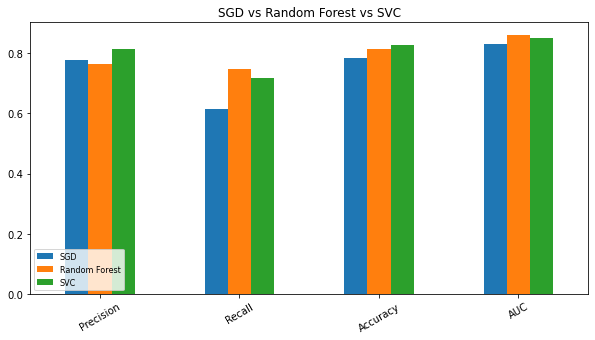

In [33]:
sgd_clf_metrics = {"Precision" : sgd_clf_precision, "Recall" : sgd_clf_recall, "Accuracy" : sgd_clf_accuracy, "AUC" : sgd_clf_AUC}
forest_clf_metrics = {"Precision" : forest_clf_precision, "Recall" : forest_clf_recall, "Accuracy" : forest_clf_accuracy, "AUC" : forest_clf_AUC}
svc_clf_metrics = {"Precision" : svc_clf_precision, "Recall" : svc_clf_recall, "Accuracy" : svc_clf_accuracy, "AUC" : svc_clf_AUC}

clf_metrics = {}
clf_metrics["SGD"] = sgd_clf_metrics
clf_metrics["Random Forest"] = forest_clf_metrics
clf_metrics["SVC"] = svc_clf_metrics

clf_metrics_df = pd.DataFrame(clf_metrics)

clf_metrics_df.plot(kind = "bar", figsize = (10,5))
plt.title("SGD vs Random Forest vs SVC")
plt.legend(["SGD", "Random Forest", "SVC"], loc='lower left',  prop={'size': 8})
plt.xticks(rotation=30, horizontalalignment="center")
plt.show()

The AUC scores for all the classifiers are quite close at just above 0.80. <br> 
The SVM classifier has the highest precision and accuracy. The classifier seems to be the best at correctly predicting surviving passengers most of the time, and also the best at  predicting actual outcomes. <br>
Also to note all classifiers have a higher precision score than recall score with varying differences. This would mean all classifiers have a greater emphasis on reducing false positives and correctly predicting surviving passengers.

In [34]:
def plot_precision_recall_vs_threshold(classifier, precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", c = "g")
    plt.plot(thresholds, recalls[:-1], "b--", label = "Recall", c = "r")
    plt.legend(["Precision","Recall"], loc='lower left',  prop={'size': 8})
    plt.xlabel("Thresholds")
    plt.ylabel("Score")
    plt.title("{} Precision/Recall Scores vs Thresholds".format(classifier))

C:\Users\angus\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  
C:\Users\angus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


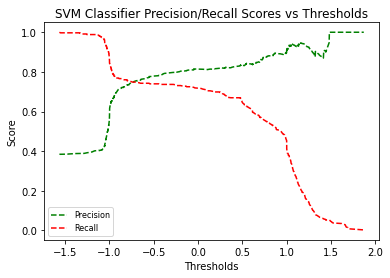

In [35]:
precisions, recalls, thresholds = precision_recall_curve(titanic_train_labels, svm_clf_scores)
plot_precision_recall_vs_threshold("SVM Classifier", precisions, recalls, thresholds)
plt.show()

Plotting the SVM Classifier's precision/recall scores for different thresholds, we can see that the precision score is greater than the recall score at the default threshold of 0 <b>

As the threshold increases, the precision score generall increases while the recall score generally decreases